In [17]:
import numpy as np
import seaborn as sns
from tqdm import tqdm
import math
from scipy.stats import poisson

# Parameters

In [18]:
initial_cases = 10

# sweep over [0.0 - 1.0]  # based on travel rates
imported_cases_per_step = .5  # really, there's a cost to setting this too, if we make it part of the action space

# .97 - .98
# .97 ** (6*30 / 4) == 0.25
# .98 ** (6*30 / 4) == 0.4
#   --> credence assigned to NO vaccine in 6 months
#        strikes balance of giving a fair chance of 6 month vaccine; while not giving high chance to vaccine in 2-months
discount = 0.99

# time step: ~4 days  (1 generation period)
num_population = 5000 # 100000

In [19]:
# is this really a fair form? 
# wouldn't keeping everyone home for 6 weeks have some finite cost?

# Cost of setting R
R_0 = 2.5   # 2.8? #3?  look up; depends on the place

# sweep:  [1, 3]
power = 2

# average person's annual economic contribution: $50,000?
economic_contribution_annual = 50000
economic_contribution_2_weeks = economic_contribution_annual * 2.0 / 52
cost_to_keep_half_home = num_population / 2 * economic_contribution_2_weeks

# want: cost_of_r(R_0 / 4) == cost_to_keep_half_home
# Better: how much economic loss has the US had, to keep R ~= 1
# (1/((R_0/4)**power) - 1/(R_0 ** power)) * scale_factor == cost_to_keep_half_home
# scale_factor = cost_to_keep_half_home / (1/((R_0/4)**power) - 1/(R_0 ** power))

# population of 100,000:
# R = 1 for 4 days  ~=  100 people getting sick (25 ppl / day * 4 days)
# every 20 days: 500 people sick -> 5 person dead

# cost_of_r(1.0) == cost_of_n(100) == cost of 1 death + other bad effects ?= $4,000,000
# [1/(1 ** power) - 1/(R_0 ** power)] * scale_factor == 100
# scale_factor = 100 / [1 - 1/(R_0 ** power)]


def cost_of_r(r, power=power):
    baseline = 1/(R_0 ** power)
    actual = 1/(r ** power)
    
    scale_factor = 100 # cost_to_keep_half_home / (1/((num_population/4)**power) - 1/(R_0 ** power))
    
    if r >= R_0:
        return 0
    else:
        return (actual - baseline) * scale_factor

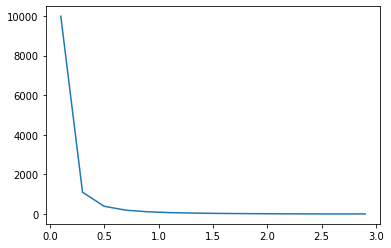

In [20]:
rs = np.arange(0.1, 3.1, 0.2)
costs_of_r = [cost_of_r(r) for r in rs]
sns.lineplot(x=rs, y=costs_of_r)

In [21]:
cost_of_r(1.0) / cost_of_r(0.5)

0.21875

In [22]:
# Cost of N (number of cases)
# assume cost of someone getting sick is $40,000

'''fraction_need_hospital = 0.04
cost_per_hospital_visit = 50000
cost_per_death = 1e6

# cost_of_n(n) == n
# cost_of_r(1.0) == cost_of_n(100) == 100

hospital_capacity = 25 # 5% of population #  20000

death_rate_hospital = 0.25
death_rate_neglected = 0.9'''


def cost_of_n(n):
    if n <= 0:
        return 0
    else:
        return n
    
    '''    num_need_hospital = n * fraction_need_hospital
        num_hospital = min(num_need_hospital, hospital_capacity)
        num_neglected = num_need_hospital - num_hospital
        num_deaths = num_neglected * death_rate_neglected + num_hospital * death_rate_hospital
        
        return cost_per_hospital_visit * num_hospital + cost_per_death * num_deaths '''

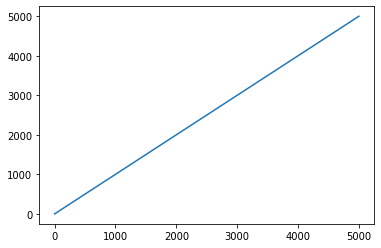

In [23]:
ns = list(range(num_population))
     # sum([list(range(100*i, 100*(i+1), i+1)) for i in range(5)], []) # + \
     # sum([list(range(1000*i, 1000*(i+1), (i+1)*10)) for i in range(1, 10)], []) + \
     #sum([list(range(10000*i, 10000*(i+1), (i+1)*100)) for i in range(1, 10)], [])
# 
costs_of_n = [cost_of_n(n) for n in ns]
sns.lineplot(x=ns, y=costs_of_n)

In [24]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [25]:
def expected_new_state(current_state, action):
    r_effective = action
    current_cases = current_state
    
    fraction_susceptible = 1 # (num_population - current_cases) / num_population
    # TODO: may need better way to bound susceptible population,
    # to account for immunity
    # One option: fraction_susceptible = 1 always, and just bound new_state by num_population

    # Better solution: keep track of how many people are susceptible NOW, based on some immunity time
    expected_new_cases = (current_cases * r_effective + imported_cases_per_step) * fraction_susceptible

    return expected_new_cases

In [26]:
def new_state_distribution(state, action):
    lam = expected_new_state(state, action)
    # TODO: change to negative binomial; look up constant in literature for COVID
    return poisson(lam)

In [27]:
def reward(state, action):
    n = state
    r_effective = action
    return -cost_of_n(n) - cost_of_r(r_effective)  # should this be cost_of_n(new_state)?

In [28]:
def step(state, action):
    # state: number of current cases (discretized)
    # action: value of R_effective to set (discretized)
    # return: new_state, reward
    
    new_state = new_state_distribution(state, action).rvs()
    
    # TODO: change to an actual expectation
    # ensure number of infected people does not exceed entire population
    new_state = min(new_state, num_population)
    
    resulting_reward = reward(state, action)
    
    new_state = find_nearest(ns, new_state)  # discretized case count
    
    return new_state, resulting_reward

## Initial Conditions

## Value Iteration

In [29]:
def select_action(state, value_table):
    rewards = {}
    new_states = np.array(ns)
    future_rewards = np.array(list(value_table.values()))
    for action in rs:
        distr = new_state_distribution(state, action)
        probs = distr.pmf(new_states)
        
        step_reward = reward(state, action) 
        # TODO: in general, this should be coupled with the probability of reaching a given state. 
        # Here, we've made them independent
        
        rewards[action] = sum(probs * (step_reward + discount * future_rewards))
    argmax_reward, max_reward = max(rewards.items(), key=lambda x: x[1])
    return argmax_reward, max_reward # action, lifetime value of taking this action

In [30]:
def state_value(state, value_table):
    best_action, max_reward = select_action(state, value_table)
    return max_reward # lifetime value of taking the best action from this state

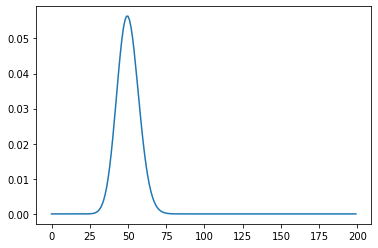

In [31]:
r = 200
lam = 50
p = lam / (r + lam)

kk = list(range(200))
probs = [poisson.pmf(k, lam) for k in kk]

sns.lineplot(x=kk, y=probs)

In [ ]:
value_table = {n: np.random.random() * -20 - 3 for n in ns}
# current_state = initial_cases
# print(value_table)
for i in tqdm(range(100)):
    new_value_table = {}
    for state in value_table:
        max_reward = state_value(state, value_table)
        new_value_table[state] = max_reward
    #print(np.array(list(new_value_table.values())))
    #print(np.array(list(value_table.values())))
    diffs = abs(np.array(list(new_value_table.values())) - np.array(list(value_table.values())))
    print(max(diffs))
    value_table = new_value_table
    sns.barplot(list(value_table.keys()),
            list(value_table.values()))

  0%|          | 0/100 [00:00<?, ?it/s]

1661.3010620472637


  1%|          | 1/100 [02:59<4:56:16, 179.56s/it]

604.2436980357448


  2%|▏         | 2/100 [05:57<4:52:40, 179.19s/it]

310.3818455177668


  3%|▎         | 3/100 [08:55<4:48:45, 178.62s/it]

222.39564405564238


  4%|▍         | 4/100 [11:53<4:45:27, 178.41s/it]

198.2475901972939


  5%|▌         | 5/100 [14:53<4:43:36, 179.12s/it]

154.6078433843278


  6%|▌         | 6/100 [17:50<4:39:38, 178.50s/it]

130.44332665629838


  7%|▋         | 7/100 [20:52<4:38:11, 179.48s/it]

121.41439263362065


  8%|▊         | 8/100 [23:51<4:34:53, 179.28s/it]

114.5536683265533


  9%|▉         | 9/100 [26:51<4:32:13, 179.49s/it]

106.3951286791895


 10%|█         | 10/100 [29:50<4:29:13, 179.48s/it]

99.45320757482682


 11%|█         | 11/100 [32:50<4:26:22, 179.58s/it]

94.16633942057558


 12%|█▏        | 12/100 [35:50<4:23:29, 179.65s/it]

90.27330911567628


 13%|█▎        | 13/100 [38:50<4:20:38, 179.75s/it]

86.5740425143074


 14%|█▍        | 14/100 [41:51<4:18:07, 180.08s/it]

82.39445026059047


 15%|█▌        | 15/100 [44:52<4:15:20, 180.25s/it]

78.83616893688213


 16%|█▌        | 16/100 [47:49<4:11:17, 179.49s/it]

75.57476793474336


 17%|█▋        | 17/100 [50:49<4:08:26, 179.60s/it]

73.73089710708916


 18%|█▊        | 18/100 [53:51<4:06:24, 180.29s/it]

66.5451110936649


 19%|█▉        | 19/100 [56:52<4:03:28, 180.36s/it]

52.36135346655817


 20%|██        | 20/100 [59:50<3:59:43, 179.80s/it]

36.70647213931295


 21%|██        | 21/100 [1:02:56<3:59:00, 181.52s/it]

23.91251027682813


 22%|██▏       | 22/100 [1:05:54<3:54:46, 180.60s/it]

15.251719157859497


 23%|██▎       | 23/100 [1:08:54<3:51:43, 180.56s/it]

9.679815589837517


 24%|██▍       | 24/100 [1:11:53<3:48:01, 180.03s/it]

6.135633574134545


 25%|██▌       | 25/100 [1:14:55<3:45:38, 180.51s/it]

3.8878054236836306


 26%|██▌       | 26/100 [1:17:59<3:43:48, 181.46s/it]

2.4632610297047677


 27%|██▋       | 27/100 [1:20:59<3:40:22, 181.12s/it]

1.5606513944804874


 28%|██▊       | 28/100 [1:23:58<3:36:30, 180.42s/it]

0.9887775292072547


 29%|██▉       | 29/100 [1:26:59<3:33:49, 180.69s/it]

0.6264559361453621


 30%|███       | 30/100 [1:29:58<3:30:02, 180.03s/it]

0.3969010716549519


 31%|███       | 31/100 [1:32:58<3:27:13, 180.20s/it]

0.2514629241040893


 32%|███▏      | 32/100 [1:36:03<3:25:53, 181.66s/it]

0.15931829028556876


 33%|███▎      | 33/100 [1:39:05<3:22:50, 181.64s/it]

0.10093860751214834


 34%|███▍      | 34/100 [1:42:04<3:19:04, 180.98s/it]

0.06395124153527831


 35%|███▌      | 35/100 [1:45:05<3:15:58, 180.91s/it]

0.04051731435743022


 36%|███▌      | 36/100 [1:48:04<3:12:22, 180.36s/it]

0.025670381419558908


 37%|███▋      | 37/100 [1:51:05<3:09:33, 180.53s/it]

0.016263873670936846


 38%|███▊      | 38/100 [1:54:04<3:06:02, 180.04s/it]

0.010304232822477388


 39%|███▉      | 39/100 [1:57:12<3:05:27, 182.42s/it]

0.0065284086807650965


 40%|████      | 40/100 [2:00:11<3:01:21, 181.37s/it]

0.004136175942107911


 41%|████      | 41/100 [2:03:12<2:58:25, 181.44s/it]

0.0026205392863403176


 42%|████▏     | 42/100 [2:06:12<2:54:44, 180.77s/it]

0.0016602838580865864


 43%|████▎     | 43/100 [2:09:13<2:51:53, 180.93s/it]

0.0010518989371348653


 44%|████▍     | 44/100 [2:12:12<2:48:29, 180.53s/it]

0.0006664471065960242


 45%|████▌     | 45/100 [2:16:34<3:07:44, 204.81s/it]

0.00042223804064178694


In [ ]:
'%E' % min(value_table.items(), key=lambda x: x[1])[1]

In [ ]:
'%E' % value_table[ns[-1]]

In [ ]:
'%E' % value_table[ns[0]]

In [ ]:
sns.barplot(list(value_table.keys()),
            list(value_table.values()))

In [ ]:
best_action_table = {state: select_action(state, value_table)[0] for state in value_table}

In [ ]:
sns.barplot(list(best_action_table.keys()),
            list(best_action_table.values()))

In [ ]:
# Roll-Out Using Optimal Policy

current_state = initial_cases
total_reward = 0
current_discount = 1

action_history = []
state_history = [current_state]

for i in tqdm(range(100)):
    action, expected_total_reward = select_action(current_state, value_table)
    new_state, new_reward = step(current_state, action)
    total_reward += new_reward * current_discount
    
    current_state = new_state
    current_discount *= discount
    
    action_history.append(action)
    state_history.append(current_state)

In [ ]:
total_reward

## Case Counts

In [ ]:
sns.lineplot(x=list(range(len(state_history))), y=state_history)

## R_{effective}

In [ ]:
sns.lineplot(x=list(range(len(action_history))), y=action_history)